# Usefull code for lab


In [54]:
# !pip install --upgrade networkx
# !pip install matplotlib
# !pip install tqdm

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import numpy as np
from numpy import inf

### Graph generation


In [20]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(0, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

In [7]:
G = gnp_random_connected_graph(15, 0.7, True)

# Algorithms

Name of student: Bohdan Pavliuk<br>
Below it`s code for bellman-ford and floyd-warshall algorithms.
We will check runtime for these algorithms and compare it with built-in one.
Also we compare runtime of these algorithms only on graphs without negative cycles,
because built-in floyd warshall does not work with these graphs correctly. However,
we write checking for negative cycles

## Bellman-Ford algorithm


### Built-in algorithm


In [8]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [35]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 3: 1
Distance to 5: 7


### Our algorithm

In [12]:
def bellman_ford(G, start_point:int = 0):
    path = {start_point: 0}
    path.update({i: float('inf') for i in list(G.nodes()) if i != start_point})
    edges = G.edges(data=True)
    i = 0
    while i <= len(list(G.nodes())):
        path_copy = path.copy()
        for node, weight in path.items():
            if weight == float('inf'):
                continue
            for edge in edges:
                if node == edge[0]:
                    path[edge[1]] = min(path[edge[1]], weight + edge[2]['weight'])
        if i == len(list(G.nodes())) and path_copy != path:
            return 'Negative cycle detected'
        elif path_copy == path:
            return path
        i += 1

    return path

Our algorithm return dictionary, where key is nodes and value - minimal path to these nodes from start node

In [34]:
try: 
    for node, path_weight in bellman_ford(G, 0).items():
        print(f"Distance to {node}:", path_weight)
except AttributeError:
    print(bellman_ford(G, 3))

Distance to 0: 0
Distance to 1: inf
Distance to 2: inf
Distance to 3: 1
Distance to 4: inf
Distance to 5: 7


#### Floyd Warshall

In [28]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

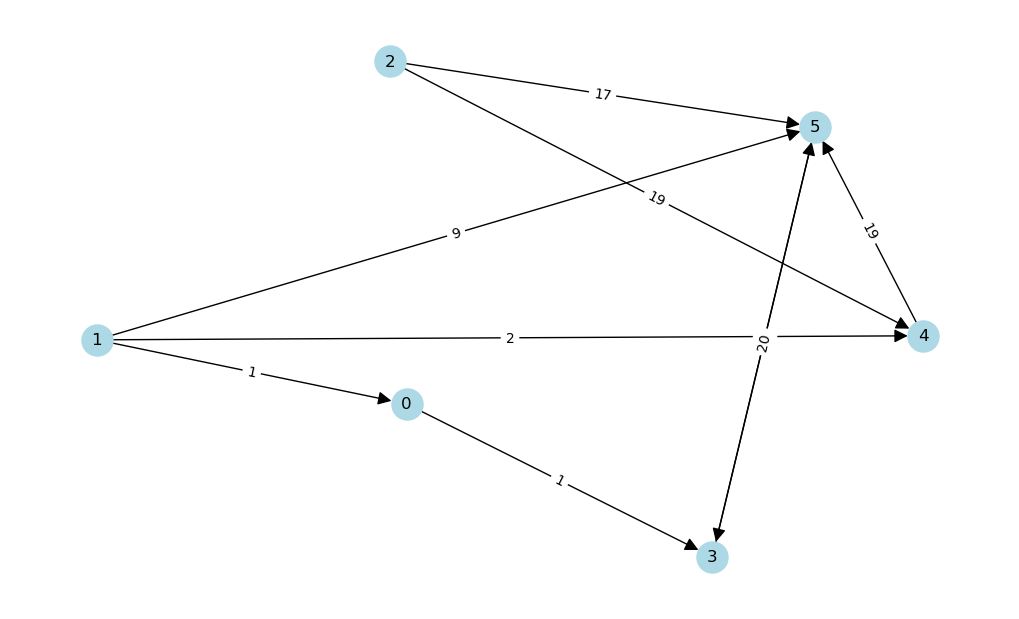

In [24]:
G = gnp_random_connected_graph(6, 0.5, True, True)

In [29]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 3: 1, 1: inf, 2: inf, 4: inf, 5: 7}
Distances with 1 source: {1: 0, 0: 1, 5: 8, 4: 2, 2: inf, 3: 2}
Distances with 2 source: {2: 0, 4: 19, 5: 17, 0: inf, 1: inf, 3: 37}
Distances with 3 source: {3: 0, 5: 6, 0: inf, 1: inf, 2: inf, 4: inf}
Distances with 4 source: {4: 0, 5: 19, 0: inf, 1: inf, 2: inf, 3: 39}
Distances with 5 source: {5: 0, 3: 20, 0: inf, 1: inf, 2: inf, 4: inf}


In [31]:
def check_negative_cycles(matrix):
    for i in range(len(matrix)):
        if matrix[i][i] < 0:
            return True
    return False

def floyd_warshall(G):
    nodes = list(G.nodes())
    matrix = np.zeros((len(nodes), len(nodes)), dtype=np.float32)
    edges = {(edge[0],edge[1]): edge[2]['weight'] for edge in G.edges(data=True)}
    #fullfill matrix with weight of each edges
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i == j and (i, j) not in edges:
                matrix[i][j] = 0
            elif (i, j) in edges:
                matrix[i][j] = edges[(i, j)]
            else:
                matrix[i][j] = inf
    i = 0
    while i + 1 <= len(nodes):

        for k in range(len(nodes)):
            for h in range(len(nodes)):
                if h == i or k == i:
                    continue
                #Update matrix
                matrix[k][h] = min(matrix[k][h], matrix[k][i] + matrix[i][h])
        #check if negative cycles are in graph
        if check_negative_cycles(matrix):
            return 'Negative cycle detected'
        i += 1
    return matrix


This algorithm will return np.matrix with dtype = float32. And also if it is any negative cycle, it will check and return 
"Negative cycle detected"

In [33]:
floyd_warshall(G)

array([[ 0., inf, inf,  1., inf,  7.],
       [ 1.,  0., inf,  2.,  2.,  8.],
       [inf, inf,  0., 37., 19., 17.],
       [inf, inf, inf,  0., inf,  6.],
       [inf, inf, inf, 39.,  0., 19.],
       [inf, inf, inf, 20., inf,  0.]], dtype=float32)

# Comperasion with built-in algorithm

In [39]:
import time
from tqdm import tqdm

In [38]:
def comparison_floyd(nodes: int, func):
  NUM_OF_ITERATIONS = 200
  time_taken = 0
  time_taken_built = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      G = gnp_random_connected_graph(nodes, 0.5, True)
      
      start = time.time()
      func(G)
      end = time.time()
      
      time_taken += end - start

      start_built = time.time()
      pred, dist = floyd_warshall_predecessor_and_distance(G)
      end_built = time.time()

      time_taken_built +=  end_built - start_built
  return(time_taken/NUM_OF_ITERATIONS, time_taken_built/NUM_OF_ITERATIONS)

In [37]:
def comparison_bellman(nodes: int, func):
  NUM_OF_ITERATIONS = 200
  time_taken = 0
  time_taken_built = 0
  for i in tqdm(range(NUM_OF_ITERATIONS)):
      
      # note that we should not measure time of graph creation
      G = gnp_random_connected_graph(nodes, 0.5, True)
      
      start = time.time()
      func(G)
      end = time.time()
      
      time_taken += end - start

      start_built = time.time()
      try:
        pred, dist = bellman_ford_predecessor_and_distance(G) 
      except:
        pass
      end_built = time.time()

      time_taken_built +=  end_built - start_built
  return(time_taken/NUM_OF_ITERATIONS, time_taken_built/NUM_OF_ITERATIONS)

### Plot of comparison with built-in algorithm


100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


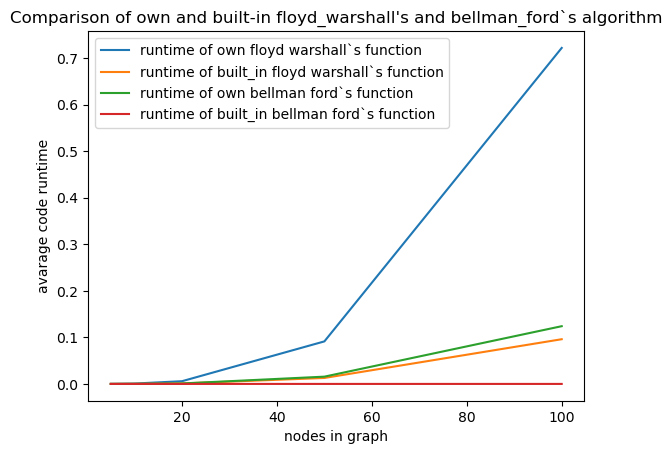

In [41]:
nodes_amount = [5, 10, 20, 50, 100]
own_maked_time_floyd = []
built_in_time_floyd = []
own_maked_time_ford = []
built_in_time_ford = []
for nodes in nodes_amount:
  own_func_floyd, built_in_func_floyd = comparison_floyd(nodes, floyd_warshall)
  own_func_ford, built_in_func_ford = comparison_bellman(nodes, bellman_ford)
  own_maked_time_floyd.append(own_func_floyd)
  built_in_time_floyd.append(built_in_func_floyd)
  own_maked_time_ford.append(own_func_ford)
  built_in_time_ford.append(built_in_func_ford)

plt.plot(nodes_amount, own_maked_time_floyd, label ='runtime of own floyd warshall`s function')
plt.plot(nodes_amount, built_in_time_floyd, label ='runtime of built_in floyd warshall`s function')
plt.plot(nodes_amount, own_maked_time_ford, label ='runtime of own bellman ford`s function')
plt.plot(nodes_amount, built_in_time_ford, label ='runtime of built_in bellman ford`s function')
plt.xlabel('nodes in graph')
plt.ylabel('avarage code runtime')
plt.title("Comparison of own and built-in floyd_warshall's and bellman_ford`s algorithm")
plt.legend()

I run my algorithms only on graphs without negative cycles. As we can see, built-in bellman ford works very fast. Own bellman ford works not so fast and on graph with 100 nodes runs around 0.1 second.<br>
If we are comparing built-in and own floyd warshall algorithms, we can see, that built-in runs in 7 times faster.
Floyd warshall works slowly, because it need to pass throught whole matrix and does it n times, where n is an amount of nodes.
And my bellman ford word not so fast, because it uses brute-force attack and does many ariphmetics operations, when it`s no 
need for it